# Differentiation Project
## Continuous or discrete? Comparing models of cellular differentiation
File: TestingFEniCS.ipynb <br>
Author: Valentin Jacot-Descombes and Peter Ashcroft <br>
E-mail: vjd.jako@gmail.com

In [1]:
from fenics import *

error L2 = 0.008235098073354827
error max 1.3322676295501878e-15


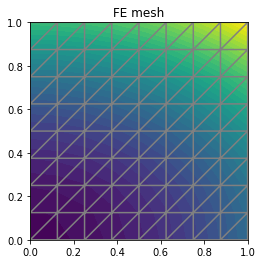

In [2]:
# %load FEniCS_tests/1_poisson.py
%matplotlib inline 

from fenics import *
import matplotlib.pyplot as plt
import numpy as np

# Create mesh and define function space
mesh = UnitSquareMesh(8, 8)  # 8X8 rectangles, each divided in 2 triangle, hence 128 cells, and 81 (9^2) vertices
V = FunctionSpace(mesh, 'P', 1)  # P returns Lagrangian polynomials, 1 is the degree of the FE

# Define boundary condition (value)
u_D = Expression('1 + x[0]*x[0] + 2*x[1]*x[1]', degree=2)


def boundary(x, on_boundary):
    return on_boundary


bc = DirichletBC(V, u_D, boundary)

# Define variational problem
uh = TrialFunction(V)  # here it is just defined as an unknown to define a.
vh = TestFunction(V)
f = Constant(-6.0)  # or Expression(’-6’, degree=0)
a = dot(grad(uh), grad(vh)) * dx  # bilinear form
L = f * vh * dx  # linear form

# Compute solution
uh = Function(V) # here we redefine it for the solver
solve(a == L, uh, bc)

# Plot Solution and Mesh
plot(uh,title= 'FE solution')
plot(mesh,title= 'FE mesh')

# save solution --> omit
# vtkfile = File('poisson/solution.pvd')
# vtkfile << uh


# Compute error in L2 norm
errorL2_var = errornorm(u_D, uh, 'L2')

# Compute maximum error at vertices
vertex_values_u_D_var = u_D.compute_vertex_values(mesh)
vertex_values_u_var = uh.compute_vertex_values(mesh)
errorMax_var = np.max(np.abs(vertex_values_u_D_var - vertex_values_u_var))

# print error
print('error L2 =', errorL2_var)
print('error max', errorMax_var)

plt.show()


In [7]:
!conda install mshr

Solving environment: done

# All requested packages already installed.



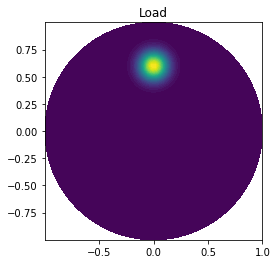

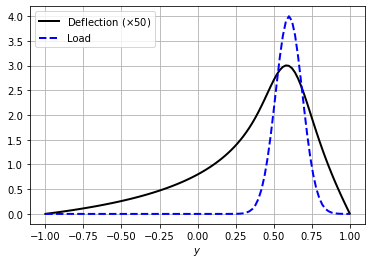

In [8]:
# %load FEniCS_tests/2_Deflection.py
%matplotlib inline

from fenics import *
import matplotlib.pyplot as plt
import numpy as np
from mshr import *

alpha = 4
beta = 8
R0 = 0.6
domain = Circle(Point(0, 0), 1)  # center and radius
mesh = generate_mesh(domain, 64)  # resolution
V = FunctionSpace(mesh, 'P', 2)

p = Expression('4*exp(-pow(beta,2)*(x[0]*x[0] + (pow(x[1] - R0,2) ) ) )', degree=1, beta=beta, R0=R0)
w_D = Constant(0)


# p.beta = 12 can be changed p.R0 = 0

def boundary(x, on_boudary):
    return on_boudary


w = TrialFunction(V)
v = TestFunction(V)
a = dot(grad(w), grad(v)) * dx
L = p * v * dx

bc = DirichletBC(V, w_D, boundary)

w = Function(V)
solve(a == L, w, bc)

p2 = interpolate(p, V)

plot(w, title='Deflection')
plot(p2, title='Load')

plt.show()

# vtkfile_w = File('poisson_membrane/deflection.pvd')
# vtkfile_w << w
# vtkfile_p = File('poisson_membrane/load.pvd')
# vtkfile_p << p2

tol = 0.001
y = np.linspace(-1 + tol, 1 - tol, 101)
points = [(0, y_) for y_ in y]
w_line = np.array([w(point) for point in points])
p_line = np.array([p2(point) for point in points])
plt.plot(y,50*w_line,'k', linewidth=2)
plt.plot(y,p_line,'b--', linewidth=2)
plt.grid(True)
plt.xlabel('$y$')
plt.legend(['Deflection ($\\times 50$)', 'Load'], loc='upper left')
plt.savefig('poisson_membrane/curves.pdf')
plt.savefig('poisson_membrane/curves.png')

plt.show()

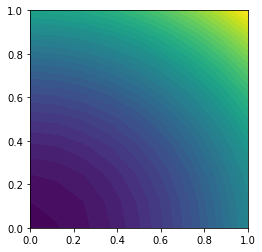

In [9]:
# %load FEniCS_tests/3_Heat_Equation.py
%matplotlib inline

from fenics import *
import numpy as np
import matplotlib.pyplot as plt

mesh = UnitSquareMesh(8, 8)
V = FunctionSpace(mesh, 'P', 1)

alpha = 1.3
beta = 1.2
T = 2.0  # final time
num_step = 10
dt = T / num_step
u_D = Expression('1 + x[0]*x[0] + alpha * x[1]*x[1] + beta * t', degree=2, alpha=alpha, beta=beta,
                 t=0)  # t is passed as a parameter


def boundary(x, on_boundary):
    return on_boundary


bc = DirichletBC(V, u_D, boundary)

# u is u(n+1) and u_n is u(n)
u_n = project(u_D, V)  # or u_n = interpolate(u_D, V)

u = TrialFunction(V)
v = TestFunction(V)
f = Constant(beta - 2 - 2 * alpha)

F = u * v * dx + dt * dot(grad(u), grad(v)) * dx - (u_n + dt * f) * v * dx
a, L = lhs(F), rhs(F)

u = Function(V)
t = 0
for n in range(num_step):
    # Update current time
    t += dt
    u_D.t = t
    # solve variational problem
    solve(a == L, u, bc)
    plot(u)
    # update previous solution
    u_e = interpolate(u_D, V)
    error = np.abs(u_e.vector().get_local() - u.vector().get_local()).max()
    #print('t= %.2f: error = %.3g' % (t, error))

    u_n.assign(u)

plt.show()


44
5.7


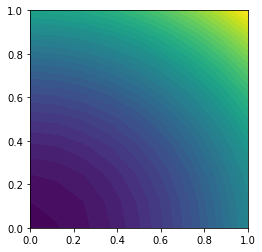

In [10]:
plot(u)
print(np.argmax(u.vector()))
print(u(1,1))

<IPython.core.display.Javascript object>


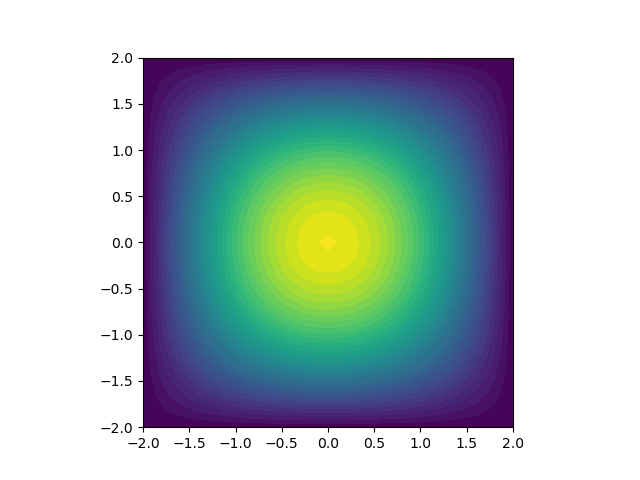

t= 0.02: error = 0.232
t= 0.04: error = 0.395
t= 0.06: error = 0.504
t= 0.08: error = 0.582
t= 0.10: error = 0.639
t= 0.12: error = 0.683
t= 0.14: error = 0.718
t= 0.16: error = 0.746
t= 0.18: error = 0.769
t= 0.20: error = 0.788
t= 0.22: error = 0.804
t= 0.24: error = 0.818
t= 0.26: error = 0.831
t= 0.28: error = 0.841
t= 0.30: error = 0.851
t= 0.32: error = 0.859
t= 0.34: error = 0.867
t= 0.36: error = 0.873
t= 0.38: error = 0.879
t= 0.40: error = 0.885
t= 0.42: error = 0.89
t= 0.44: error = 0.895
t= 0.46: error = 0.899
t= 0.48: error = 0.903
t= 0.50: error = 0.907
t= 0.52: error = 0.91
t= 0.54: error = 0.913
t= 0.56: error = 0.916
t= 0.58: error = 0.919
t= 0.60: error = 0.922
t= 0.62: error = 0.924
t= 0.64: error = 0.927
t= 0.66: error = 0.929
t= 0.68: error = 0.931
t= 0.70: error = 0.933
t= 0.72: error = 0.935
t= 0.74: error = 0.937
t= 0.76: error = 0.939
t= 0.78: error = 0.941
t= 0.80: error = 0.942
t= 0.82: error = 0.944
t= 0.84: error = 0.945
t= 0.86: error = 0.947
t= 0.88: erro

In [4]:
#### %load FEniCS_tests/4_Heat_Gaussian.py
%matplotlib notebook
from fenics import *
import numpy as np
import matplotlib.pyplot as plt

nx = ny = 30
mesh = RectangleMesh(Point(-2, -2), Point(2, 2), nx, ny)
V = FunctionSpace(mesh, 'P', 1)

a = 5
T = 2.0  # final time
num_step = 100
dt = T / num_step

u_0 = Expression('exp(-a*x[0]*x[0] - a* x[1]*x[1]) ', degree=2, a=a)


def boundary(x, on_boundary):
    return on_boundary


zero = Constant(0)
bc = DirichletBC(V, zero, boundary)

u_n = project(u_0, V)  # or u_n = interpolate(u_D, V)

u = TrialFunction(V)
v = TestFunction(V)
f = Constant(0)

F = u * v * dx + dt * dot(grad(u), grad(v)) * dx - (u_n + dt * f) * v * dx
a, L = lhs(F), rhs(F)
vtkfile = File('heat_gaussian/solution.pvd')

u = Function(V)
t = 0
for n in range(num_step):
    # Update current time
    t += dt
    # solve variational problem
    solve(a == L, u, bc)

    vtkfile << (u, t)
    plot(u)
    # update previous solution
    u_e = interpolate(u_0, V)
    error = np.abs(u_e.vector().get_local() - u.vector().get_local()).max()
    print('t= %.2f: error = %.3g' % (t, error))

    u_n.assign(u)
# plot(mesh)
plt.show()
#The plot can be viewed in Paraview as a video

u = x[0] + 2*x[1] + 1
f = -10*x[0] - 20*x[1] - 10
f_50
 error max = 2.4e-10


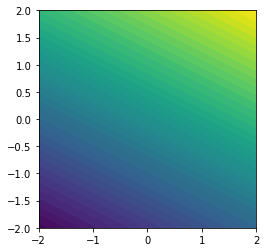

In [1]:
# %load FEniCS_tests/5_Nonlinear_Poisson.py
%matplotlib inline
# Warning: from fenics import * will import both ‘sym‘ and
# ‘q‘ from FEniCS. We therefore import FEniCS first and then
# overwrite these objects.

from fenics import *
import numpy as np
import matplotlib.pyplot as plt


def q(u):
    "Return nonlinear coefficients"
    return 1 + u ** 2


import sympy as sym

x, y = sym.symbols('x[0], x[1]')  # usually x,y but here we will use these for the
u = 1 + x + 2 * y
f = -sym.diff(q(u) * sym.diff(u, x), x) - sym.diff(q(u) * sym.diff(u, y), y)
f = sym.simplify(f)
u_code = sym.printing.ccode(u)
f_code = sym.printing.ccode(f)
print('u =', u_code)
print('f =', f_code)

nx = ny = 30
mesh = RectangleMesh(Point(-2, -2), Point(2, 2), nx, ny)
V = FunctionSpace(mesh, 'P', 1)

a = 5
T = 2.0  # final time
num_step = 10
dt = T / num_step

u_D = Expression(u_code, degree=1)
f = Expression(f_code, degree=1)


def boundary(x, on_boundary):
    return on_boundary


bc = DirichletBC(V, u_D, boundary)

# u_n = project(u_D, V)  # or u_n = interpolate(u_D, V)

u = Function(V)
v = TestFunction(V)

F = q(u) * dot(grad(u), grad(v)) * dx - f * v * dx

solve(F == 0, u, bc)

plot(u)
# update previous solution
u_e = interpolate(u_D, V)
print(u_e)
error = np.abs(u_e.vector().get_local() - u.vector().get_local()).max()
print(' error max = %.3g' % error)

plt.show();


In [2]:
# %load FEniCS_tests/5_Nonlinear_Poisson.py
%matplotlib inline
# Warning: from fenics import * will import both ‘sym‘ and
# ‘q‘ from FEniCS. We therefore import FEniCS first and then
# overwrite these objects.

from fenics import *
import numpy as np
import matplotlib.pyplot as plt


def q(u):
    "Return nonlinear coefficients"
    return 1 + u ** 2


import sympy as sym

x, y = sym.symbols('x[0], x[1]')  # usually x,y but here we will use these for the
u = 1 + x + 2 * y
f = -sym.diff(q(u) * sym.diff(u, x), x) - sym.diff(q(u) * sym.diff(u, y), y)
f = sym.simplify(f)
u_code = sym.printing.ccode(u)
f_code = sym.printing.ccode(f)
print('u =', u_code)
print('f =', f_code)

nx = ny = 30
mesh = RectangleMesh(Point(-2, -2), Point(2, 2), nx, ny)
V = FunctionSpace(mesh, 'P', 1)

a = 5
T = 2.0  # final time
num_step = 10
dt = T / num_step

u_D = Expression(u_code, degree=1)
f = Expression(f_code, degree=1)


def boundary(x, on_boundary):
    return on_boundary

materials = CellFunction('size_t',mesh)

bc = DirichletBC(V, u_D, boundary)

# u_n = project(u_D, V)  # or u_n = interpolate(u_D, V)

u = Function(V)
v = TestFunction(V)

F = q(u) * dot(grad(u), grad(v)) * dx - f * v * dx

solve(F == 0, u, bc)

plot(u)
# update previous solution
u_e = interpolate(u_D, V)
print(u_e)
error = np.abs(u_e.vector().get_local() - u.vector().get_local()).max()
print(' error max = %.3g' % error)

plt.show();


u = x[0] + 2*x[1] + 1
f = -10*x[0] - 20*x[1] - 10


NameError: name 'CellFunction' is not defined

In [13]:
# %load FEniCS_tests/6_Linear_Elasticity.py
%matplotlib inline
from fenics import *
import numpy as np
import matplotlib.pyplot as plt
from ufl import nabla_grad, nabla_div
# from mpl_toolkits import mplot3d
# from mpl_toolkits.mplot3d import Axes3D
# from mpl_toolkits.mplot3d import axes3d

L = 1
W = 0.2
mu = 1
rho = 1000
delta = W / L
gamma = 0.4 * delta ** 2
beta = 1.25
lambda_ = beta
g = gamma

mesh = BoxMesh(Point(0, 0, 0), Point(L, W, W), 10, 3, 3)
V = VectorFunctionSpace(mesh, 'P', 1)

tol = 1E-14


def clamped_boundary(x, on_boundary):
    return on_boundary and x[0] < tol


bc = DirichletBC(V, Constant((0, 0, 0)), clamped_boundary)


def epsilon(u_):
    return 0.5 * (nabla_grad(u_) + nabla_grad(u_).T)


def sigma(u_):
    return lambda_ * nabla_div(u_) * Identity(d) + 2 * mu * epsilon(u_)


u = TrialFunction(V)
d = u.geometric_dimension()
print(epsilon(u))
v = TestFunction(V)
f = Constant((0, 0, -rho * g))
T = Constant((0, 0, 0))
a = inner(sigma(u), epsilon(v)) * dx
L = dot(f, v) * dx + dot(T, v) * ds

u = Function(V)
solve(a == L, u, bc)

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
#
# ax.plot_surface(u)
#
#

s = sigma(u) - (1/3.)* tr(sigma(u)) * Identity(d)
von_Misses = sqrt(3./2*inner(s,s))
V = FunctionSpace(mesh, 'P', 1)
von_Misses = project(von_Misses, V)

u_magnitude = sqrt(dot(u,u))
u_magnitude = project(u_magnitude, V)
print('min/max u:',
      u_magnitude.vector().get_local().min(),
      u_magnitude.vector().get_local().max())
# Save solution to file in VTK format
File('elasticity/displacement.pvd') << u
File('elasticity/von_mises.pvd') << von_Misses
File('elasticity/magnitude.pvd') << u_magnitude

# plot(u_magnitude)


{ A | A_{i_{12}, i_{13}} = 0.5 * (((nabla_grad(v_1))^T) + (nabla_grad(v_1)))[i_{12}, i_{13}] }
min/max u: -0.003879704751367573 154.58538332268802


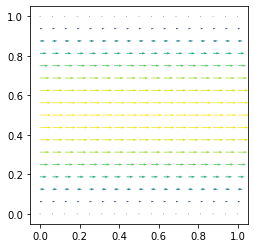

In [8]:
# %load FEniCS_tests/7_Navier_Stokes.py# 
%matplotlib inline
from fenics import *
import numpy as np
import matplotlib.pyplot as plt
from ufl import nabla_grad, nabla_div


T = 10.0
num_steps = 500
dt = T / num_steps
L = 1
H = 1
mu = 1
rho = 1

# mesh = BoxMesh(Point(0, 0, 0), Point(L, H, H), 10, 3, 3)

mesh = UnitSquareMesh(16,16)

V = VectorFunctionSpace(mesh, 'P', 2)
Q = FunctionSpace(mesh, 'P', 1)

# boundary = 'near(x[0], 0)' # boundary expression example
inflows = 'near(x[0],0)'
outflows = 'near(x[0],1)'
walls = 'near(x[1], 0) || near(x[1],1)'

bcu_noslip = DirichletBC(V, Constant((0, 0)), walls)
bcp_inflow = DirichletBC(Q, Constant(8), inflows)
bcp_outflow = DirichletBC(Q, Constant(0), outflows)
bcu = [bcu_noslip]
bcp = [bcp_inflow, bcp_outflow]

# sym = symetric
def epsilon(u_):
    return sym(nabla_grad(u_))


def sigma(u_, p):
    return 2 * mu * epsilon(u_) - p * Identity(len(u))


u = TrialFunction(V)
v = TestFunction(V)
p = TrialFunction(Q)
q = TestFunction(Q)

u_n = Function(V)
u_1 = Function(V)
# dot((u-u_n)/k,v)*dx
p_n = Function(Q)
p_1 = Function(Q)

U = 0.5 * (u_n + u)
n = FacetNormal(mesh)
f = Constant((0, 0))
k = Constant(dt)
mu = Constant(mu)
rho = Constant(rho)

F1 = rho*dot((u-u_n)/k,v)*dx + rho*dot(dot(u_n, nabla_grad(u_n)),v)*dx + \
     inner(sigma(U,p_n),epsilon(v))*dx + dot(p_n*n,v)*ds -dot(mu*nabla_grad(U)*n, v)*ds - dot(f,v)*dx
a1 = lhs(F1)
L1 =  rhs(F1)

a2 = dot(nabla_grad(p),nabla_grad(q))*dx
L2 = dot(nabla_grad(p_n), nabla_grad(q))* dx - (1/k)*div(u_1)*q*dx

a3 = dot(u, v)*dx
L3 = dot(u_1, v)*dx - k*dot(nabla_grad(p_1 - p_n), v)*dx

A1 = assemble(a1)
A2 = assemble(a2)
A3 = assemble(a3)

[bc.apply(A1) for bc in bcu]
[bc.apply(A2) for bc in bcp]

t = 0
for n in range(num_steps):
    t += dt

    b1 = assemble(L1)
    [bc.apply(b1) for bc in bcu]
    solve(A1, u_1.vector(), b1)

    b2 = assemble(L2)
    [bc.apply(b2) for bc in bcp]
    solve(A2, p_1.vector(), b2)

    b3 = assemble(L3)
    solve(A3, u_1.vector(), b3)


    u_e = Expression(('4*x[1]*(1.0 - x[1])', '0'), degree=2)
    u_e = interpolate(u_e, V)
    error = np.abs(u_e.vector().get_local() - u_1.vector().get_local()).max()
#     print('t= %f: error = %.3g' % (t,error))
#     print('max u: ', u_1.vector().get_local().max())

    u_n.assign(u_1)
    p_n.assign(p_1)
    
plot(u_1)

plt.show()

In [6]:
print(u_1.vector()[:].shape)

(2178,)


In [ ]:
# %load FEniCS_tests/8_Navier_Stokes.py
%matplotlib inline

from fenics import *
# from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
from ufl import nabla_grad, nabla_div
from mshr import *

T = 5.0
num_steps = 5000
dt = T / num_steps

mu = 0.001
rho = 1

channel = Rectangle(Point(0, 0), Point(2.2, 0.41))
cylinder = Circle(Point(0.2, 0.2), 0.05)
domain = channel - cylinder
mesh = generate_mesh(domain, 64)

V = VectorFunctionSpace(mesh, 'P', 2)
Q = FunctionSpace(mesh, 'P', 1)

# boundary = 'near(x[0], 0)' # boundary expression example
inflows = 'near(x[0], 0)'
outflows = 'near(x[0], 2.2)'
walls = 'near(x[1], 0) || near(x[1],0.41)'
cylinder = 'on_boundary && x[0] > 0.1 && x[0] < 0.3 && x[1] > 0.1 && x[1] < 0.3'

inflow_profile = ('4.0*1.5*x[1]*(0.41 - x[1]) / pow(0.41, 2)', '0')

# bcu_noslip = DirichletBC(V, Constant((0, 0)), walls)
bcp_inflow = DirichletBC(V, Expression(inflow_profile, degree=2), inflows)
bcp_outflow = DirichletBC(Q, Constant(0), outflows)

bcu_walls = DirichletBC(V, Constant((0, 0)), walls)
bcu_cylinder = DirichletBC(V, Constant((0, 0)), cylinder)
bcu = [bcp_inflow, bcu_walls, bcu_cylinder]
bcp = [bcp_outflow]


def epsilon(u_):
    return sym(nabla_grad(u_))


def sigma(u_, p):
    return 2 * mu * epsilon(u_) - p * Identity(len(u))


u = TrialFunction(V)
v = TestFunction(V)
p = TrialFunction(Q)
q = TestFunction(Q)

u_n = Function(V)
u_1 = Function(V)
p_n = Function(Q)
p_1 = Function(Q)

U = 0.5 * (u_n + u)
n = FacetNormal(mesh)
f = Constant((0, 0))
k = Constant(dt)
mu = Constant(mu)
rho = Constant(rho)

F1 = rho * dot((u - u_n) / k, v) * dx + rho * dot(dot(u_n, nabla_grad(u_n)), v) * dx + \
     inner(sigma(U, p_n), epsilon(v)) * dx + dot(p_n * n, v) * ds - dot(mu * nabla_grad(U) * n, v) \
     * ds - dot(f, v) * dx
a1 = lhs(F1)
L1 = rhs(F1)

a2 = dot(nabla_grad(p), nabla_grad(q)) * dx
L2 = dot(nabla_grad(p_n), nabla_grad(q)) * dx - (1 / k) * div(u_1) * q * dx

a3 = dot(u, v) * dx
L3 = dot(u_1, v) * dx - k * dot(nabla_grad(p_1 - p_n), v) * dx

A1 = assemble(a1)
A2 = assemble(a2)
A3 = assemble(a3)

[bc.apply(A1) for bc in bcu]
[bc.apply(A2) for bc in bcp]

xdmfile_u = XDMFFile('NS_cylinder/velocity.xdmf')
xdmfile_p = XDMFFile('NS_cylinder/pressure.xdmf')

timeseries_u = TimeSeries('NS_cylinder/velocity_series')
timeseries_p = TimeSeries('NS_cylinder/pressure_series')

File('NS_cylinder/cylinder.xml.gz') << mesh

progress = dolfin.Progress('Time stepping', num_steps)
set_log_level(0)

t = 0.0
for n in range(num_steps):
    t += dt

    b1 = assemble(L1)
    [bc.apply(b1) for bc in bcu]
    solve(A1, u_1.vector(), b1, 'bicgstab', 'hypre_amg')

    b2 = assemble(L2)
    [bc.apply(b2) for bc in bcp]
    solve(A2, p_1.vector(), b2, 'bicgstab', 'hypre_amg')

    b3 = assemble(L3)
    solve(A3, u_1.vector(), b3, 'cg', 'sor')

    plot(u_1, title='Velocity')
    plot(p_1, title='Pressure')

    xdmfile_u.write(u_1, t)
    xdmfile_p.write(p_1, t)

    timeseries_u.store(u_1.vector(), t)
    timeseries_p.store(p_1.vector(), t)

    # u_e = Expression(('4*x[1]*(1.0 - x[1])', '0'), degree=2)
    # u_e = interpolate(u_e, V)
    # error = np.abs(u_e.vector().get_local() - u_1.vector().get_local()).max()
    # print('t= %f: error = %.3g' % (t,error))
    #print('max u: ', u_1.vector().get_local().max())

    u_n.assign(u_1)
    p_n.assign(p_1)

    progress += 0

plt.show()


In [ ]:
# %load FEniCS_tests/9_Advection_Diffusion.py
%matplotlib inline

from fenics import *
# from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
from ufl import nabla_grad, nabla_div
from mshr import *

T = 5.0
num_steps = 500
dt = T/num_steps
eps = 0.01
K = 10.0


mesh = Mesh('NS_cylinder/cylinder.xml.gz')

W = VectorFunctionSpace(mesh, 'P', 2)

timeseries_w = TimeSeries('NS_cylinder/velocity_series')

P1 = FiniteElement('P', triangle, 1)
element = MixedElement([P1,P1,P1])
V = FunctionSpace(mesh, element)

# for mixed Function Space we need TestFunctions and not TestFunction
v_1, v_2, v_3 = TestFunctions(V)

w = Function(W)
u = Function(V)
u_n = Function(V)

u_1, u_2, u_3 = split(u)
u_n1, u_n2, u_n3 = split(u_n)

# Define the source Term
f_1 = Expression('pow(x[0] - 0.1,2) + pow(x[1]-0.1,2) < 0.05 * 0.05 ? 0.1 : 0', degree=1)
f_2 = Expression('pow(x[0] - 0.1,2) + pow(x[1]-0.3,2) < 0.05 * 0.05 ? 0.1 : 0', degree=1)
f_3 = Constant(0)

k = Constant(dt)
K = Constant(K)
eps = Constant(eps)

F = ((u_1- u_n1)/k)*v_1*dx + dot(w,grad(u_1))*v_1*dx + eps*dot(grad(u_1), grad(v_1))*dx + K * u_1*u_2*v_1*dx \
    + ((u_2 -u_n2)/K)*v_2*dx + dot(w, grad(u_2))*v_2*dx + eps*dot(grad(u_2), grad(v_2))*dx + K * u_1*u_2*v_2*dx \
    + ((u_3 -u_n3)/K)*v_3*dx + dot(w, grad(u_3))*v_3*dx + eps*dot(grad(u_3), grad(v_3))*dx - K * u_1*u_2*v_3*dx \
    + K*u_3*v_3*dx -f_1*v_1*dx -f_2*v_2*dx -f_3*v_3*dx

vtkfile_u1 = File('AD_system/u_1.pvd')
vtkfile_u2 = File('AD_system/u_2.pvd')
vtkfile_u3 = File('AD_system/u_3.pvd')

t=0
for n in range(num_steps):
    t+=dt
    timeseries_w.retrieve(w.vector(),t)
    solve(F==0, u)
    u_1_, u_2_, u_3_ = u.split()
    vtkfile_u1 << (u_1_,t)
    vtkfile_u2 << (u_2_,t)
    vtkfile_u3 << (u_3_,t)
    u_n.assign(u)

plt.show()
print('Finished')